<a href="https://colab.research.google.com/github/landge/pytorch_mri/blob/master/live_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install nilearn

In [0]:
import nibabel as nib
from nilearn.plotting import plot_anat
import matplotlib.pyplot as plt
import imageio
import numpy as np
%matplotlib inline
from IPython.display import display

## Milestone 1

In [0]:
root_dir = '/content/gdrive/My Drive/live_project/data/small'

In [0]:
p = Path(root_dir)
t1 = p/'t1'
t2 = p/'t2'

In [0]:
t1_paths = [f for f in t1.glob('*')]
t2_paths = [f for f in t2.glob('*')]

In [0]:
t1_subjects = [x.name[:6] for x in t1_paths]
t2_subjects = [x.name[:6] for x in t2_paths]
assert t1_subjects.sort() == t2_paths.sort()
subs = t1_subjects

In [0]:
t1_and_t2_dict = {sub[0]: {'t1':sub[1], 't2':sub[2]} for sub in zip(subs, t1_paths, t2_paths)}

In [0]:
def plot_mris(image_pair):
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,9))

  ax[0].imshow(image_pair['t1'][5,:,:], cmap='gray', origin='lower')
  print(image_pair['t1'].shape)
  ax[0].set_title('T1')
  ax[1].imshow(image_pair['t2'][5,:,:], cmap='gray', origin='lower')
  ax[1].set_title('T2')

  plt.show()
  

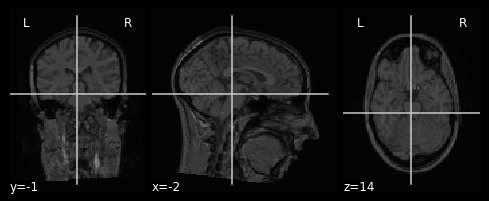

In [10]:
plot_anat(t1_and_t2_dict[subs[0]]['t1'].as_posix())

## Milestone 2

In [0]:
from torch.utils.data.dataset import Dataset

In [12]:
t2

PosixPath('/content/gdrive/My Drive/live_project/data/small/t2')

In [0]:
from collections import namedtuple

In [0]:
class NiftiDataset(Dataset):
  """
  Create a dataset class in PyTorch for reading NifTI files.

  Args:
        source_dir (str): path to source images
        target_dir (str): path to target images
        transforms (Callable): transform to apply to both target and source images.
  
  """
  def __init__(self, source_dir, target_dir, transform=None):
    """
    Path should be python Path-objects!
    
    """
    self.source_dir = source_dir if isinstance(source_dir, Path) else Path(source_dir)
    self.target_dir = target_dir if isinstance(target_dir, Path) else Path(target_dir)

    self.transform = transform

    self.source_niftis = sorted([nifti for nifti in self.source_dir.glob('*.nii.gz')])  
    self.target_niftis = sorted([nifti for nifti in self.target_dir.glob('*.nii.gz')])

    self.len_source_niftis = len(self.source_niftis)
    self.len_target_niftis = len(self.target_niftis)

    assert self.len_source_niftis == self.len_target_niftis , f"Different numbers of source and target images! Source images: {self.len_source_niftis}! Target images: {self.len_target_niftis}"
    
    self.image_pairs = [{'t1': image_pair[0], 't2': image_pair[1]} for image_pair in zip(self.source_niftis, self.target_niftis)]

  def __len__(self):
    return len(self.source_niftis)
    
  def __getitem__(self, idx):
    image_pair = self.image_pairs[idx]
    image_data = {}

    for contrast, image in image_pair.items():
      image_data[contrast] = nib.load(image).get_fdata()[30:,:,:]

    if self.transform:
      image_data = (self.transform(image_data))
      return image_data
    else:
      return image_data



90 120 90
23 41 61
33 51 71
(10, 10, 10)


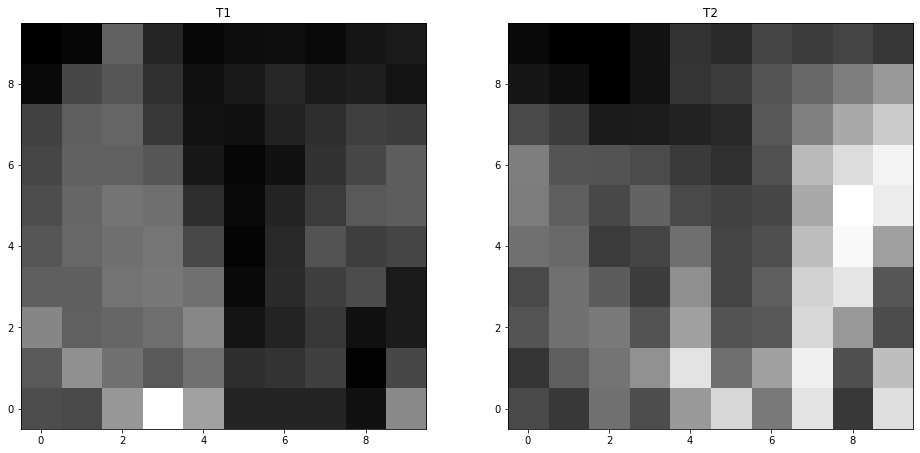

In [22]:
plot_mris(test[0])

In [0]:
class RandomCrop3D(object):
  """
  Randomly crop a 3d patch from a (pair of) 3d images.

  Args:
    output_size (tuple or int): Desired output size.
        If int, cube crop is made.
  """
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size, output_size)
    else:
      assert len(output_size) == 3
      self.output_size = output_size
    print(self.output_size)

  
  def __call__(self, image_pair):
    assert image_pair['t1'].shape == image_pair['t2'].shape
    trans_output = {}
    x_size, y_size, z_size = image_pair['t1'].shape
    #print(x_size, y_size, z_size)
    x_ran = np.random.randint(0, x_size - self.output_size[0])
    y_ran = np.random.randint(0, y_size - self.output_size[1])
    z_ran = np.random.randint(0, z_size - self.output_size[2])
    #print(x_ran, y_ran, z_ran)
    x_tran = x_ran + self.output_size[0] 
    y_tran = y_ran + self.output_size[1]
    z_tran = z_ran + self.output_size[2]
    #print(x_tran, y_tran, z_tran)
    

    for contrast in ['t1','t2']:
       trans_output[contrast] = image_pair[contrast][x_ran:x_tran, y_ran:y_tran, z_ran:z_tran]
    
    return trans_output



    
    




In [18]:
crop = RandomCrop3D(10)

(10, 10, 10)


In [0]:
test = NiftiDataset(t1, t2, crop)